In [1]:
import tensorflow as tf
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table

In [3]:
#Load a TF model
models = sorted(glob.glob('./models/*.h5'))
model_1 = models[1]
model = tf.keras.models.load_model(models[1])

#Load data
Imgs = np.load('./Fe_Flux/data/FeMC_8-120-SCD0_imgs.npy')
Angles = np.load('./Fe_Flux/data/FeMC_8-120-SCD0_angles.npy')
TrueE = np.load('./Fe_Flux/data/FeMC_8-120-SCD0_trueE.npy')
Energy_true = np.log10(TrueE)

X = Imgs
X0 = Angles

#Reshape data
img_rows, img_cols = X[0].shape
input_shape = (img_rows, img_cols, 1)
X = X.reshape(X.shape[0], img_rows, img_cols, 1)
X = X.astype('float32')
X0 = np.reshape(Angles, (len(X0),1))

#Make predictions
prediction = model.predict([X, X0])
Energy_ML = np.reshape(prediction, (len(prediction), ))

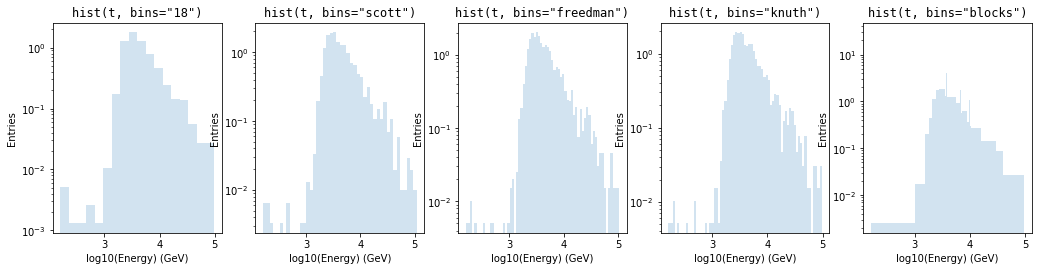

In [3]:
#Compare different binning methods of histograms
from astropy.visualization import hist

fig, ax = plt.subplots(1, 5, figsize=(16, 4))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)

for i, bins in enumerate([18, 'scott', 'freedman', 'knuth', 'blocks']):
    
    hist(Energy_true, bins=bins, ax=ax[i], histtype='stepfilled',
            alpha=0.2, density=True)
    ax[i].set_yscale('log')
    ax[i].set_xlabel('log10(Energy) (GeV)')
    ax[i].set_ylabel('Entries')
    ax[i].set_title(f'hist(t, bins="{bins}")',
                    fontdict=dict(family='monospace'))   

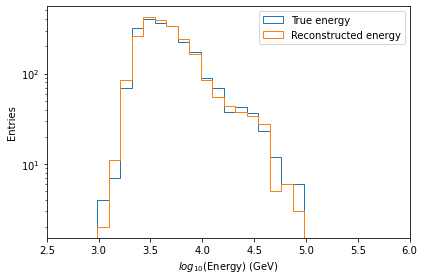

In [4]:
from astropy.visualization import hist

h0 = hist(Energy_true, bins = 18, range=(Energy_true.min(),Energy_true.max()), histtype='step', label='True energy')
h1 = hist(Energy_ML, bins = 18, range=(Energy_true.min(),Energy_true.max()), histtype='step', label='Reconstructed energy')
#https://docs.astropy.org/en/stable/api/astropy.stats.knuth_bin_width.html#astropy.stats.knuth_bin_width

plt.yscale('log')
plt.xlim(2.5, 6)
plt.xlabel(r'$log_{10}$(Energy) (GeV)')
plt.ylabel('Entries')
plt.legend()
plt.tight_layout()

x0 = []
for i in range(1, len(h0[1])):
    x0.append( (h0[1][i] + h0[1][i-1])/2 ) #bin center in log10(GeV)
x0 = np.array(x0)

dE0 = []
for j in range(1, len(h0[1])):
    dE0.append(10**h0[1][j] - 10**h0[1][j-1]) #bin size in GeV
dE0 = np.array(dE0)

gamma = 2.5
y0 = h0[0]/dE0*(10**x0)**gamma
y0 = h0[0]/dE0*(10**x0)**gamma

#Error calculation
#https://docs.astropy.org/en/stable/api/astropy.stats.poisson_conf_interval.html
from astropy import stats

y0_lo_err0 = y0 - (stats.poisson_conf_interval(h0[0], interval='frequentist-confidence'))[0]/dE0*(10**x0)**gamma
y0_up_err0 = (stats.poisson_conf_interval(h0[0], interval='frequentist-confidence'))[1]/dE0*(10**x0)**gamma - y0
y0_up_err1 = (stats.poisson_conf_interval(h0[0], interval='frequentist-confidence',sigma=2))[1]/dE0*(10**x0)**gamma - y0

x1 = []
for i in range(1, len(h1[1])):
    x1.append( (h1[1][i] + h1[1][i-1])/2 ) #bin center in log10(GeV)
x1 = np.array(x1)

dE1 = []
for j in range(1, len(h1[1])):
    dE1.append(10**h1[1][j] - 10**h1[1][j-1]) #bin size in GeV
dE1 = np.array(dE1)

y1 = h1[0]/dE1*(10**x1)**gamma
y1 = h1[0]/dE1*(10**x1)**gamma

y1_lo_err0 = y1 - (stats.poisson_conf_interval(h1[0], interval='frequentist-confidence'))[0]/dE1*(10**x1)**gamma
y1_up_err0 = (stats.poisson_conf_interval(h1[0], interval='frequentist-confidence'))[1]/dE1*(10**x1)**gamma - y1
y1_up_err1 = (stats.poisson_conf_interval(h1[0], interval='frequentist-confidence',sigma=2))[1]/dE1*(10**x1)**gamma - y1



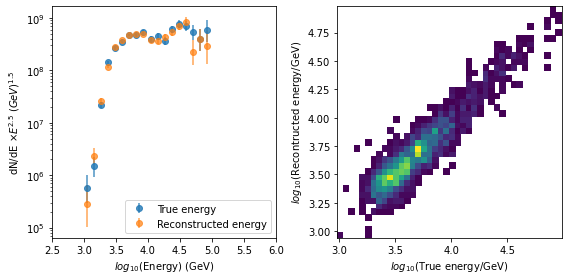

In [38]:
'''
zero_data = np.logical_not(y0.astype('bool')) #data points with zero entries
zero_idx = np.where(zero_data==True)[0]
x_zero_data = x0[zero_idx]
y_zero_data = y0_up_err1[zero_idx]
uplims = np.array([1 for _ in range(len(zero_idx))], dtype=bool)

idx = np.where(y0.astype('bool')==True)[0] #data points with non-zero entries
'''
plt.figure(figsize=(8 ,4))
plt.subplot(121)
plt.errorbar(x0, y0, yerr = [y0_lo_err0, y0_up_err0], marker='o', linestyle='', alpha=0.8, label='True energy')
plt.errorbar(x1, y1, yerr = [y1_lo_err0, y1_up_err0], marker='o', linestyle='', alpha=0.7, label='Reconstructed energy')
#plt.errorbar(x_zero_data, y_zero_data, yerr = y_zero_data/1.5, uplims=uplims, marker=7,linestyle='')

plt.yscale('log')
plt.xlim(2.5, 6)
#plt.ylim(1e-6, 1)

plt.legend()
plt.xlabel(r'$log_{10}$(Energy) (GeV)')
plt.ylabel(r'dN/dE $\times E^{2.5}\ (GeV)^{1.5}$') 

plt.subplot(122)
plt.hist2d(Energy_true, Energy_ML, bins=40, cmin=0.01)
plt.xlabel(r'$log_{10}$(True energy/GeV)')
plt.ylabel(r'$log_{10}$(Recontructed energy/GeV)')

plt.tight_layout()

In [18]:
x = x0

A0 = 0.364358
A1 = 3.29957
A2 = 0.135761
G = A0*(1 - np.exp(-(x-A1)/A2))*np.heaviside(x-A1, 0)

#t = 13996800
t = 6938784
#e = 0.32*0.40
#e = 0.40 # 8-120 cut only, defined by #event after 8-120/#event >1.9TeV

B0 = 0.60986744
B1 = 3.30849844
B2 = 0.11200669
e_cut = B0*(1 - np.exp(-(x-B1)/B2))*np.heaviside(x-B1, 0)
e = 0.45*e_cut # 8-120 + charge selection (24.5 < Z of SCD0 < 28)
e1 = 0.45*eff

y_true = y0/(e*G*t)
y_recon = y1/(e*G*t)
y_recon1 = y1/(e1*G*t) #don't use fits

e_err = 0.2*e
G_err = 0.05*0.35
t_err = 0.15*t

y_true_err_up = abs(y_true)*np.sqrt( (y0_up_err0/y0)**2 + (e_err/e)**2 + (G_err/0.35)**2 + (t_err/t)**2 )
y_true_err_lo = abs(y_true)*np.sqrt( (y0_lo_err0/y0)**2 + (e_err/e)**2 + (G_err/0.35)**2 + (t_err/t)**2 )

y_recon_err_up = abs(y_recon)*np.sqrt( (y1_up_err0/y0)**2 + (e_err/e)**2 + (G_err/0.35)**2 + (t_err/t)**2 )
y_recon_err_lo = abs(y_recon)*np.sqrt( (y1_lo_err0/y0)**2 + (e_err/e)**2 + (G_err/0.35)**2 + (t_err/t)**2 )




<ipython-input-18-64bba1319bdd>:20: RuntimeWarning: divide by zero encountered in true_divide
  y_true = y0/(e*G*t)
<ipython-input-18-64bba1319bdd>:21: RuntimeWarning: divide by zero encountered in true_divide
  y_recon = y1/(e*G*t)
<ipython-input-18-64bba1319bdd>:22: RuntimeWarning: divide by zero encountered in true_divide
  y_recon1 = y1/(e1*G*t) #don't use fits
<ipython-input-18-64bba1319bdd>:28: RuntimeWarning: invalid value encountered in true_divide
  y_true_err_up = abs(y_true)*np.sqrt( (y0_up_err0/y0)**2 + (e_err/e)**2 + (G_err/0.35)**2 + (t_err/t)**2 )
<ipython-input-18-64bba1319bdd>:29: RuntimeWarning: invalid value encountered in true_divide
  y_true_err_lo = abs(y_true)*np.sqrt( (y0_lo_err0/y0)**2 + (e_err/e)**2 + (G_err/0.35)**2 + (t_err/t)**2 )
<ipython-input-18-64bba1319bdd>:31: RuntimeWarning: invalid value encountered in true_divide
  y_recon_err_up = abs(y_recon)*np.sqrt( (y1_up_err0/y0)**2 + (e_err/e)**2 + (G_err/0.35)**2 + (t_err/t)**2 )
<ipython-input-18-64bba1319

In [28]:
y_recon

array([          inf,           inf,           inf,  879.31724719,
        680.31253792,  672.12220769,  742.90433544,  747.54065062,
        730.84643805,  548.2153016 ,  524.8674517 ,  615.14234772,
        778.92063504, 1022.15681553, 1234.78201959,  323.46017163,
        569.41626741,  417.67409024])

Text(0.5, 1.0, 'Fe flux $\\times$ E$^{2.5}$')

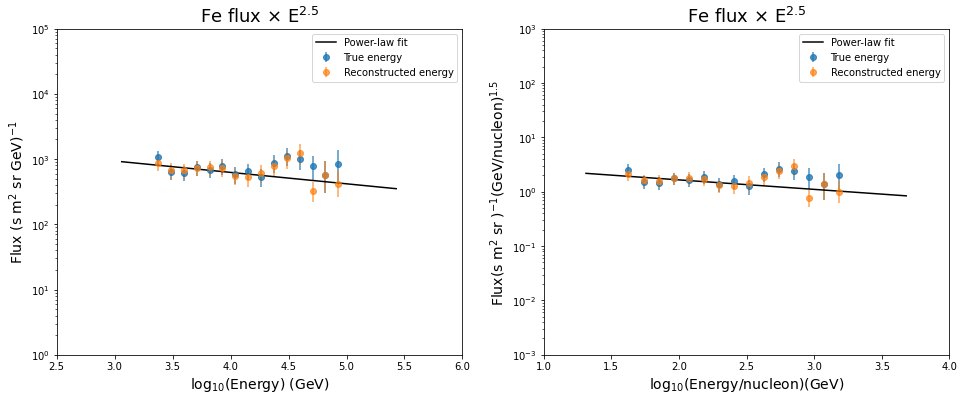

In [47]:
#plot data
plt.figure(figsize=(16,6))

plt.subplot(121)

plt.errorbar(x0, y_true, yerr=[y_true_err_lo, y_true_err_up], marker='o', linestyle='', alpha=0.8, label='True energy')
plt.errorbar(x1, y_recon, yerr=[y_recon_err_lo, y_recon_err_up], marker='o', linestyle='', alpha=0.7, label='Reconstructed energy')
#plt.errorbar(x1, y_recon1, yerr=[y_recon_err_lo, y_recon_err_up], marker='o', linestyle='', alpha=0.7, label='Reconstructed energy')

plt.yscale('log')

#plot fitted line
def fit_func(x, Phi0, alpha):
    return 1e-3*Phi0*(x/1e3)**(-alpha)

# Fit the function to data
from scipy.optimize import curve_fit

err = (y_recon_err_up + y_recon_err_lo)/2
start_idx = 3
best_pars, covss = curve_fit(fit_func, 10**x1[start_idx:], y_recon[start_idx:],\
                             sigma=err[start_idx:], absolute_sigma=True)
E = np.logspace(2,6) #in GeV
fit_idx = np.where ((np.log10(E) > 3) & (np.log10(E) < 5.5 )) [0] #only cover data points x1
plt.plot(np.log10(E)[fit_idx], fit_func(E[fit_idx], best_pars[0], best_pars[1]), \
         color='black', label='Power-law fit') 


plt.xlim(2.5, 6)
plt.ylim(1e0, 1e5)
plt.legend()
plt.title(r'Fe flux $\times$ E$^{2.5}$',fontsize=18)
plt.xlabel(r'$\rm log_{10}$(Energy) (GeV)',fontsize=14)
plt.ylabel(r'Flux $(\rm s\ m^2\ sr\ GeV)^{-1}$',fontsize=14)

plt.subplot(122)

plt.errorbar(x0-np.log10(56), y_true*56**(-1.5), yerr=[y_true_err_lo*56**(-1.5),\
                                                       y_true_err_up*56**(-1.5)], marker='o', linestyle='', alpha=0.8, label='True energy')
plt.errorbar(x1-np.log10(56), y_recon*56**(-1.5), yerr=[y_recon_err_lo*56**(-1.5),\
                                                        y_recon_err_up*56**(-1.5)], marker='o', linestyle='', alpha=0.7, label='Reconstructed energy')

plt.plot(np.log10(E)[fit_idx]-np.log10(56), \
         fit_func(E[fit_idx], best_pars[0], best_pars[1])*56**(-1.5), \
         color='black', label='Power-law fit') 

plt.yscale('log')

plt.xlim(1, 4)
plt.ylim(1e-3, 1e3)
plt.legend()
plt.xlabel(r'$\rm log_{10}(Energy/nucleon) (GeV)$',fontsize=14)
plt.ylabel(r'$\rm Flux (s\ m^2\ sr\ )^{-1}(GeV/nucleon)^{1.5}$',fontsize=14)
plt.title(r'Fe flux $\times$ E$^{2.5}$',fontsize=18)

In [39]:
best_pars[1]-2.5

-2.325158228200874

Text(0.5, 1.0, 'Fe flux $\\times$ E$^{2.5}$')

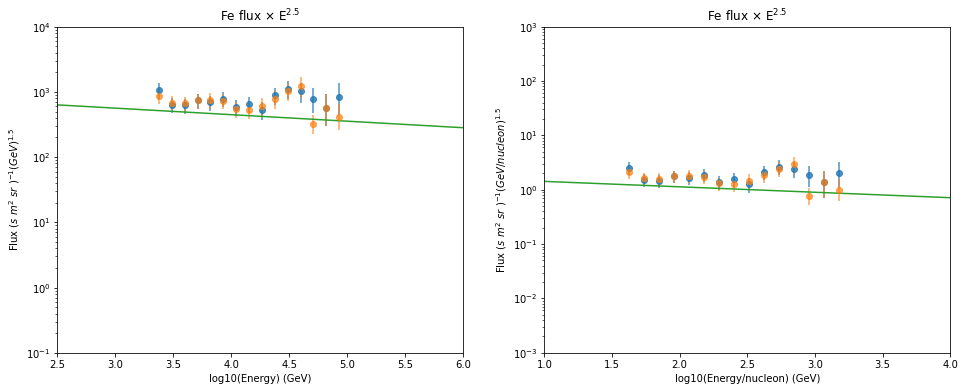

In [17]:
#plot data
plt.figure(figsize=(16,6))

plt.subplot(121)

plt.errorbar(x0, y_true, yerr=[y_true_err_lo, y_true_err_up], marker='o', linestyle='', alpha=0.8, label='True energy')
plt.errorbar(x1, y_recon, yerr=[y_recon_err_lo, y_recon_err_up], marker='o', linestyle='', alpha=0.7, label='Reconstructed energy')

plt.yscale('log')

#plot reference spectrum
phi0 = 1.78*1e-2
E = np.logspace(2,6) #in GeV
a = 2.6
phi = 1e-3*phi0*(E/1e3)**(-a)
plt.plot(np.log10(E), phi*E**gamma)

plt.xlim(2.5, 6)
plt.ylim(1e-1, 1e4)
plt.xlabel('log10(Energy) (GeV)')
plt.ylabel(r'Flux $(s\ m^2\ sr\ )^{-1}(GeV)^{1.5}$')
plt.title(r'Fe flux $\times$ E$^{2.5}$')

plt.subplot(122)

plt.errorbar(x0-np.log10(56), y_true*56**(-1.5), yerr=[y_true_err_lo*56**(-1.5),\
                                                       y_true_err_up*56**(-1.5)], marker='o', linestyle='', alpha=0.8, label='True energy')
plt.errorbar(x1-np.log10(56), y_recon*56**(-1.5), yerr=[y_recon_err_lo*56**(-1.5),\
                                                        y_recon_err_up*56**(-1.5)], marker='o', linestyle='', alpha=0.7, label='Reconstructed energy')
plt.plot(np.log10(E)-np.log10(56), phi*E**gamma*56**(-1.5))

plt.yscale('log')

plt.xlim(1, 4)
plt.ylim(1e-3, 1e3)
plt.xlabel('log10(Energy/nucleon) (GeV)')
plt.ylabel(r'Flux $(s\ m^2\ sr\ )^{-1}(GeV/nucleon)^{1.5}$')
plt.title(r'Fe flux $\times$ E$^{2.5}$')

In [12]:
eff = np.array([0.1, 0.1, 0.12515723, 0.23467292, 0.49339623, \
       0.52817824, 0.64510166, 0.59714286, 0.64705882, 0.61676647, \
       0.64454976, 0.49655172, 0.75700935, 0.73333333, 0.6       , \
       0.5       , 0.75      , 0.5       ])